## BIRDCLEF 2024 - Rami El Wazzi & Sacha Guenoun

### Partie 3 - Training

#### Objectif du projet : entrainer un réseau de neurones permettant de reconnaitre un oiseau grâce à son cri.

In [1]:
import pandas as pd
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from tensorflow.keras.optimizers import RMSprop, Adam, SGD

### Chargement des propriétés du signal calculées en partie 2

In [2]:
X = np.load("./X.npy")
y = np.load("./y.npy")
df_train = pd.read_csv("./birdclef-2024/train_metadata.csv")[["primary_label", "filename"]]

In [3]:
X.shape

(24459, 684)

In [4]:
# concatenate X to df_train

df_train["X"] = X.tolist()

# def get_max_audio_length(file_paths):
#     max_length = 0
#     for file_path in file_paths:
#         y, sr = librosa.load(file_path, sr=None)
#         length = len(y)
#         if length > max_length:
#             max_length = length
#     return max_length

# file_paths = df_train['filename'].apply(lambda x: "./birdclef-2024/train_audio/" + x).tolist()

# max_length = get_max_audio_length(file_paths)
# print(f"The maximum length of the audio files is: {max_length} samples")
max_length = 190855200 # already calculated, takes too long to calculate


In [5]:
df_train

,primary_label,filename,X
0,asbfly,asbfly/XC134896.ogg,"[-79.97372436523438, -79.92324829101562, -79.5..."
1,asbfly,asbfly/XC164848.ogg,"[-15.896378517150879, -16.278581619262695, -16..."
2,asbfly,asbfly/XC175797.ogg,"[-58.841304779052734, -53.871551513671875, -55..."
3,asbfly,asbfly/XC207738.ogg,"[-18.35483741760254, -15.606270790100098, -16...."
4,asbfly,asbfly/XC209218.ogg,"[-14.528952598571777, -8.531251907348633, -9.6..."
...,...,...,...
24454,zitcis1,zitcis1/XC845747.ogg,"[-10.991899490356445, -12.973498344421387, -17..."
24455,zitcis1,zitcis1/XC845817.ogg,"[-9.823176383972168, -15.329643249511719, -24...."
24456,zitcis1,zitcis1/XC856176.ogg,"[-26.30453872680664, -12.45651626586914, -8.18..."
24457,zitcis1,zitcis1/XC856723.ogg,"[-24.176374435424805, -19.10907745361328, -18...."


In [6]:
len(df_train["X"]), len(df_train["X"].iloc[0])

(24459, 684)

### Après plusieurs essais tests, nous décidons d'entrainer un CNN contenant l'image du spectrogramme (partie 1) ET les propriétés du signal (partie 2) pour s'assurer la meilleure accuracy.

Chargement des images du spectrogramme

In [7]:
# function to get the rgb spectrogram of the file in filename

import librosa

def get_spectrogram(filename):
    y, sr = librosa.load(filename, sr=None)
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    S_dB = librosa.power_to_db(S, ref=np.max)
    return S_dB

In [8]:
class CFG:
    sample_rate = 32000
    nfft = 2028
    hop_length = 512
    fmin = 20
    fmax = 16000
    img_height = 128
    img_width = 128  # Fixed width for all spectrograms
    batch_size = 16  # Batch size for processing
    data_dir = './birdclef-2024/train_audio/'
    output_dir = './processed_spectrograms/'
    seed = 42
    patience = 10
    num_classes = 182
    epochs = 50

In [9]:
# Convert string labels to categorical codes
df_train['label_code'] = pd.Categorical(df_train['primary_label']).codes

# Save the mapping for later use (if needed)
label_mapping = dict(enumerate(pd.Categorical(df_train['primary_label']).categories))


In [10]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [11]:
# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert labels to categorical
y = to_categorical(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X.shape, y.shape)
# Define the neural network model
def create_model(input_shape, optimizer='adam'):
    model = Sequential([
        Dense(256, input_shape=(input_shape,), activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dense(y_train.shape[1], activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

(24459, 684) (24459, 182)


In [12]:
model_adam = create_model(X_train.shape[1], optimizer='adam')
history_adam = model_adam.fit(X_train, y_train, epochs=200, batch_size=256, validation_data=(X_test, y_test))
loss_adam, accuracy_adam = model_adam.evaluate(X_test, y_test)

model_nadam = create_model(X_train.shape[1], optimizer='nadam')
history_nadam = model_nadam.fit(X_train, y_train, epochs=200, batch_size=256, validation_data=(X_test, y_test))
loss_nadam, accuracy_nadam = model_nadam.evaluate(X_test, y_test)

model_adagrad = create_model(X_train.shape[1], optimizer='adagrad')
history_adagrad = model_adagrad.fit(X_train, y_train, epochs=200, batch_size=256, validation_data=(X_test, y_test))
loss_adagrad, accuracy_adagrad = model_adagrad.evaluate(X_test, y_test)

model_rmsprop = create_model(X_train.shape[1], optimizer='rmsprop')
history_rmsprop = model_rmsprop.fit(X_train, y_train, epochs=200, batch_size=256, validation_data=(X_test, y_test))
loss_rmsprop, accuracy_rmsprop = model_rmsprop.evaluate(X_test, y_test)

model_adamax = create_model(X_train.shape[1], optimizer='adamax')
history_adamax = model_adamax.fit(X_train, y_train, epochs=200, batch_size=256, validation_data=(X_test, y_test))
loss_adamax, accuracy_adamax = model_adamax.evaluate(X_test, y_test)

model_ftrl = create_model(X_train.shape[1], optimizer='ftrl')
history_ftrl = model_ftrl.fit(X_train, y_train, epochs=200, batch_size=256, validation_data=(X_test, y_test))
loss_ftrl, accuracy_ftrl = model_ftrl.evaluate(X_test, y_test)

model_sgd_momentum = create_model(X_train.shape[1], optimizer=SGD(momentum=0.9))
history_sgd_momentum = model_sgd_momentum.fit(X_train, y_train, epochs=200, batch_size=256, validation_data=(X_test, y_test))
loss_sgd_momentum, accuracy_sgd_momentum = model_sgd_momentum.evaluate(X_test, y_test)

model_amsgrad = create_model(X_train.shape[1], optimizer=Adam(amsgrad=True))
history_amsgrad = model_amsgrad.fit(X_train, y_train, epochs=200, batch_size=256, validation_data=(X_test, y_test))
loss_amsgrad, accuracy_amsgrad = model_amsgrad.evaluate(X_test, y_test)


C:\Users\Rami\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0264 - loss: 5.0343 - val_accuracy: 0.1030 - val_loss: 4.2949
Epoch 2/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0890 - loss: 4.2719 - val_accuracy: 0.1578 - val_loss: 3.9157
Epoch 3/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1233 - loss: 3.9675 - val_accuracy: 0.1772 - val_loss: 3.6962
Epoch 4/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1466 - loss: 3.8019 - val_accuracy: 0.2016 - val_loss: 3.5586
Epoch 5/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1690 - loss: 3.6565 - val_accuracy: 0.2189 - val_loss: 3.4268
Epoch 6/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1861 - loss: 3.5432 - val_accuracy: 0.2343 - val_loss: 3.3734
Epoch 7/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2029 - loss: 3.4697 - val_accuracy: 0.2486 - val_loss: 3.2950
Epoch 8/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2075 - loss: 3.4325 - val_accuracy: 0.2610 - v

In [13]:
print(f"Adam Test Accuracy: {accuracy_adam:.4f}, Adam Test Loss: {loss_adam:.4f}")
print(f"Nadam Test Accuracy: {accuracy_nadam:.4f}, Nadam Test Loss: {loss_nadam:.4f}")
print(f"Adagrad Test Accuracy: {accuracy_adagrad:.4f}, Adagrad Test Loss: {loss_adagrad:.4f}")
print(f"RMSprop Test Accuracy: {accuracy_rmsprop:.4f}, RMSprop Test Loss: {loss_rmsprop:.4f}")
print(f"Adamax Test Accuracy: {accuracy_adamax:.4f}, Adamax Test Loss: {loss_adamax:.4f}")
print(f"FTRL Test Accuracy: {accuracy_ftrl:.4f}, FTRL Test Loss: {loss_ftrl:.4f}")
print(f"SGD with Momentum Test Accuracy: {accuracy_sgd_momentum:.4f}, SGD with Momentum Test Loss: {loss_sgd_momentum:.4f}")
print(f"Adam with AMSGrad Test Accuracy: {accuracy_amsgrad:.4f}, Adam with AMSGrad Test Loss: {loss_amsgrad:.4f}")


Adam Test Accuracy: 0.3863, Adam Test Loss: 2.6628
Nadam Test Accuracy: 0.3949, Nadam Test Loss: 2.6548
Adagrad Test Accuracy: 0.3927, Adagrad Test Loss: 2.6564


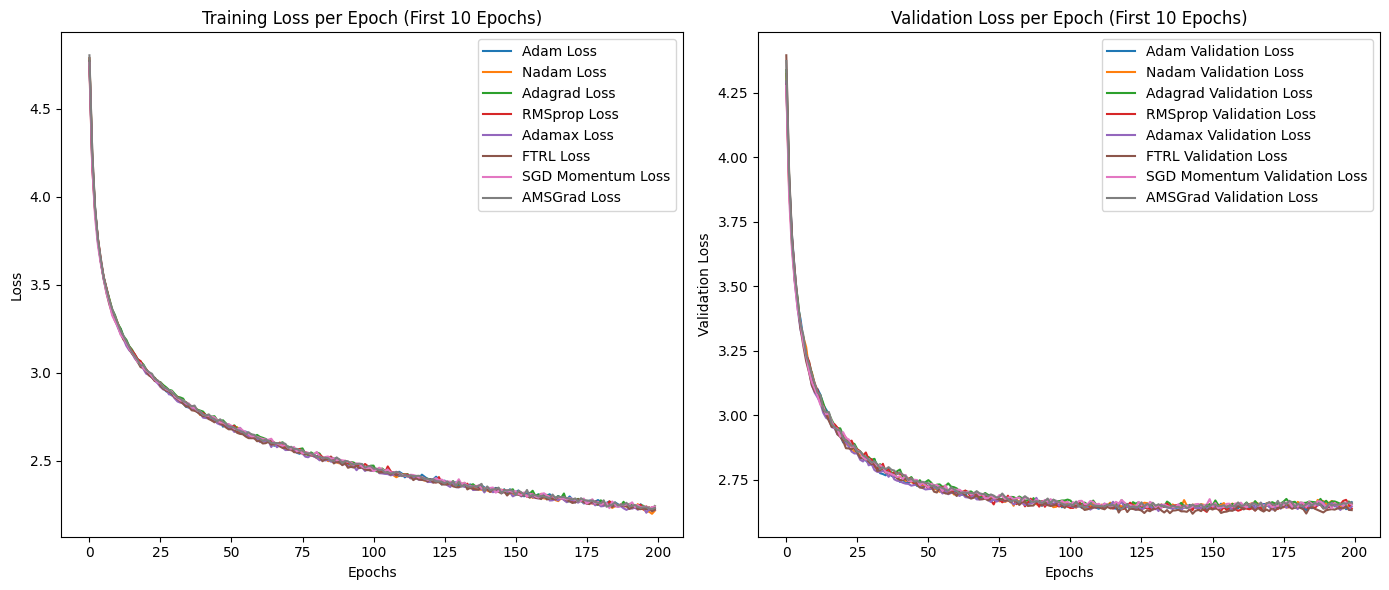

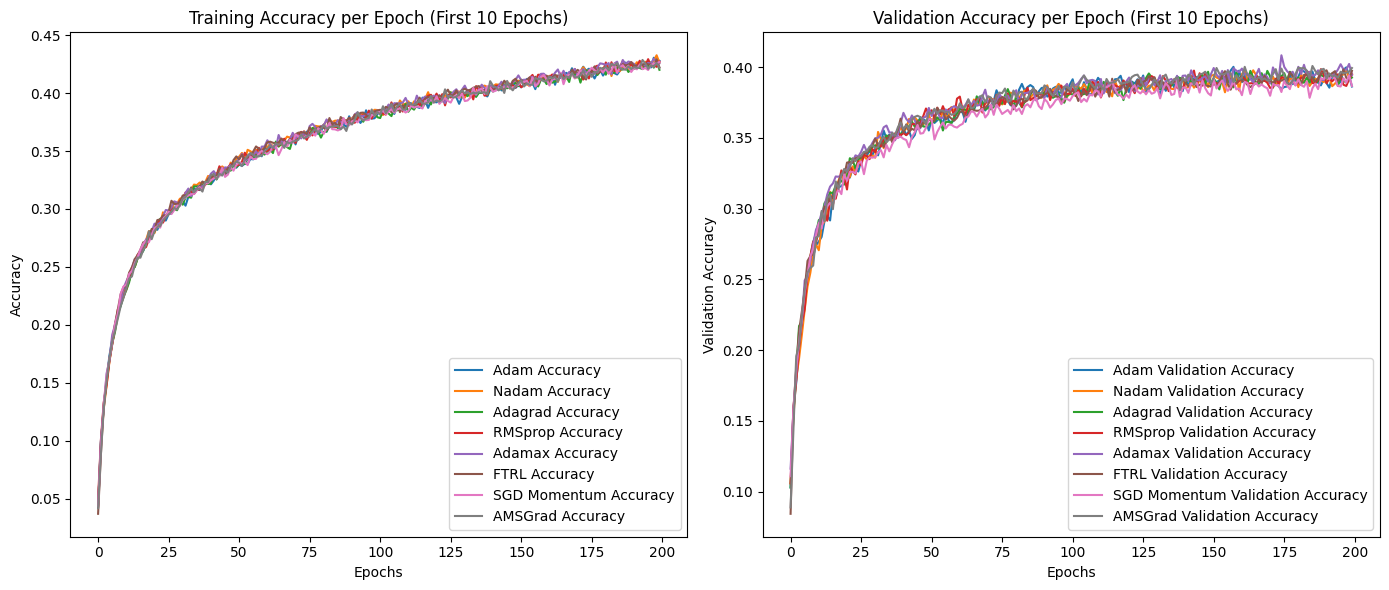

In [24]:
import matplotlib.pyplot as plt

def plot_histories(histories, epochs_range, title_suffix=''):
    """
    Plots the training and validation losses and accuracies for the given histories over the specified range of epochs.

    Parameters:
    - histories: a dictionary where the keys are labels (e.g., 'Adam') and the values are history objects from model.fit().
    - epochs_range: a range of epochs to plot (e.g., range(10)).
    - title_suffix: a string to append to the title of the plots.
    """
    epochs_range = list(epochs_range)  # Convert range to list
    
    # Plotting the loss for each optimizer
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    for label, history in histories.items():
        plt.plot(epochs_range, [history.history['loss'][i] for i in epochs_range], label=f'{label} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training Loss per Epoch {title_suffix}')
    plt.legend()

    plt.subplot(1, 2, 2)
    for label, history in histories.items():
        plt.plot(epochs_range, [history.history['val_loss'][i] for i in epochs_range], label=f'{label} Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Loss')
    plt.title(f'Validation Loss per Epoch {title_suffix}')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Plotting the accuracy for each optimizer
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    for label, history in histories.items():
        plt.plot(epochs_range, [history.history['accuracy'][i] for i in epochs_range], label=f'{label} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'Training Accuracy per Epoch {title_suffix}')
    plt.legend()

    plt.subplot(1, 2, 2)
    for label, history in histories.items():
        plt.plot(epochs_range, [history.history['val_accuracy'][i] for i in epochs_range], label=f'{label} Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Accuracy')
    plt.title(f'Validation Accuracy per Epoch {title_suffix}')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage:
histories = {
    'Adam': history_adam,
    'Nadam': history_nadam,
    'Adagrad': history_adagrad,
    'RMSprop': history_rmsprop,
    'Adamax': history_adamax,
    'FTRL': history_ftrl,
    'SGD Momentum': history_sgd_momentum,
    'AMSGrad': history_amsgrad
}

# Plotting for the first 10 epochs
plot_histories(histories, range(0, 200), title_suffix='(First 10 Epochs)')

# Plotting for a different range of epochs, e.g., epochs 10 to 20
# plot_histories(histories, range(10, 20), title_suffix='(Epochs 10 to 20)')